#### Import libraries

In [1]:
pip install mord

You are using pip version 9.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import mord as md
import pandas as pd
import numpy as np
from sklearn import metrics
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

#### Define ordered logistic functions

In [24]:
def OL_summary_output(model):
    
    #Computes coefficients
    params = model.coef_
    
    #Computes predictions
    prediction = model.predict(x)

    #Computes metrics
    MSE = metrics.mean_squared_error(y, prediction)

    #Creates summary dataframe
    coeff_df = pd.DataFrame(params, x.columns, columns=['Coefficient'])

    #Computes variance
    var_b = MSE*(np.linalg.inv(np.dot(x.T,x)).diagonal())

    #Computes standard error
    sd_b = np.sqrt(var_b)

    #Computes t-statistic
    ts_b = params/sd_b

    #Computes p-values
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(x)-1))) for i in ts_b]

    #Computes confidence intervals
    conf_int_inf = params - 1.96*sd_b
    conf_int_sup = params + 1.96*sd_b

    #Formats numbers for table
    sd_b = sd_b
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    #Summarizes dataframe
    coeff_df["Standard Errors"],coeff_df["t values"],coeff_df["Probabilites"], coeff_df['2.5%'], coeff_df['97.5%'] = [sd_b,ts_b,p_values, conf_int_inf, conf_int_sup]
    
    return coeff_df

def odds_ratio_summary_output(model_summary_output):
    
    model_summary_output = OL_summary_output(model_ordinal)
    coeff_OR = model_summary_output.copy()
    
    coeff_OR["Coefficient"] = np.exp(model_summary_output["Coefficient"])
    coeff_OR["Standard Errors"] = np.exp(model_summary_output["Standard Errors"])
    coeff_OR['2.5%'] = np.exp(coeff_OR['2.5%'])
    coeff_OR['97.5%'] = np.exp(coeff_OR['97.5%'])
    
    return coeff_OR

#### Read data

In [25]:
data = pd.read_csv('chis_data.csv')
data.head()

soda_per_week  fast_food  monthly_earnings  homeowner  acc_produce  \
0            1.0        2.0            5000.0          1            3   
1            1.0        1.0               0.0          0            4   
2           21.0        2.0            3000.0          1            4   
3            0.0        1.0            2000.0          1            4   
4            1.0        3.0               0.0          0            4   

  health_status  acc_produce_ALWAYS  acc_produce_NEVER  acc_produce_SOMETIMES  \
0     EXCELLENT                   0                  0                      0   
1          GOOD                   1                  0                      0   
2     EXCELLENT                   1                  0                      0   
3          GOOD                   1                  0                      0   
4     VERY GOOD                   1                  0                      0   

   acc_produce_USUALLY  health_status_recode  
0                    1                     1  
1                    0                     2  
2                    0                     1  
3                    0                     2  
4                    0                     1

In [26]:
data['health_status_recode'] = np.where(data['health_status']=='POOR', 1,
                                       np.where((data['health_status']=='FAIR')|(data['health_status']=='GOOD'),2,3))

data.groupby(by = ['health_status', 'health_status_recode']).size()

health_status  health_status_recode
EXCELLENT      3                       2074
FAIR           2                       1297
GOOD           2                       3158
POOR           1                        201
VERY GOOD      3                       3295
dtype: int64

### Ordinal Logit Regression

#### Define dependent & independent variables

In [27]:
ind_vars = ['soda_per_week', 'fast_food', 'monthly_earnings', 'homeowner',
            'acc_produce_SOMETIMES', 'acc_produce_USUALLY', 'acc_produce_ALWAYS'] ### Baseline is NEVER

y = data['health_status_recode']
x = data[ind_vars]

##### Run the model

In [28]:
model_ordinal = md.LogisticAT().fit(x, y)

##### Model statistics output

In [29]:
OL_summary_output(model_ordinal)

Coefficient  Standard Errors  t values  Probabilites  \
soda_per_week            -0.021941         0.001334   -16.448         0.000   
fast_food                -0.072054         0.002864   -25.155         0.000   
monthly_earnings          0.000037         0.000001    31.741         0.000   
homeowner                 0.421567         0.013469    31.300         0.000   
acc_produce_SOMETIMES     0.049463         0.025452     1.943         0.052   
acc_produce_USUALLY       0.131300         0.021681     6.056         0.000   
acc_produce_ALWAYS        0.499309         0.012667    39.419         0.000   

                           2.5%     97.5%  
soda_per_week         -0.024555 -0.019326  
fast_food             -0.077668 -0.066439  
monthly_earnings       0.000035  0.000040  
homeowner              0.395169  0.447966  
acc_produce_SOMETIMES -0.000422  0.099348  
acc_produce_USUALLY    0.088806  0.173794  
acc_produce_ALWAYS     0.474483  0.524136

In [30]:
odds_ratio_summary_output(model_ordinal)

Coefficient  Standard Errors  t values  Probabilites  \
soda_per_week             0.978298         1.001335   -16.448         0.000   
fast_food                 0.930481         1.002869   -25.155         0.000   
monthly_earnings          1.000037         1.000001    31.741         0.000   
homeowner                 1.524348         1.013560    31.300         0.000   
acc_produce_SOMETIMES     1.050707         1.025778     1.943         0.052   
acc_produce_USUALLY       1.140310         1.021917     6.056         0.000   
acc_produce_ALWAYS        1.647583         1.012747    39.419         0.000   

                           2.5%     97.5%  
soda_per_week          0.975744  0.980859  
fast_food              0.925272  0.935720  
monthly_earnings       1.000035  1.000040  
homeowner              1.484634  1.565125  
acc_produce_SOMETIMES  0.999578  1.104451  
acc_produce_USUALLY    1.092869  1.189810  
acc_produce_ALWAYS     1.607183  1.688999

#### Predicted probabilities

In [31]:
exc, good, poor = zip(*model_ordinal.predict_proba(x))

df_predict = data.copy()
df_predict['pred_exc'], df_predict['pred_good'], df_predict['pred_poor'] = exc, good, poor

###### Categorical variable

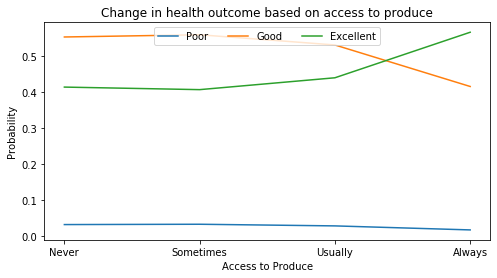

In [35]:
# Aggregate data by access to produce and compute the mean of the probability
df_predict_plot = df_predict.groupby(by = 'acc_produce').agg(np.mean)[['pred_exc', 'pred_good', 'pred_poor']]

df_predict_plot.plot(figsize = (8,4))

positions = (1, 2, 3, 4)
labels = ('Never', 'Sometimes', 'Usually', 'Always')
plt.xticks(positions, labels)

plt.xlabel ('Access to Produce')
plt.ylabel ('Probability')
plt.title ('Change in health outcome based on access to produce')

lab = ('Poor', 'Good', 'Excellent')
plt.legend(loc='upper center', ncol=3, labels = lab);

In [33]:
data.to_csv('data.csv')

##### Continous variable

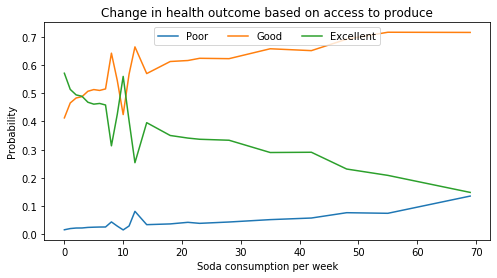

In [36]:
x = 'soda_per_week'
y = ['pred_exc', 'pred_good', 'pred_poor']

df_predict_plot = df_predict.groupby(by = x).agg(np.mean)[y].reset_index()

df_predict_plot.plot(x, y, figsize = (8,4));

plt.xlabel ('Soda consumption per week')
plt.ylabel ('Probability')
plt.title ('Change in health outcome based on access to produce')

lab = ('Poor', 'Good', 'Excellent')
plt.legend(loc='upper center', ncol=3, labels = lab);